In [6]:
pip install qiskit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install qiskit-aer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import qiskit;
print(qiskit.__version__)

2.0.0


Found 22 classes: ['.DS_Store', 'agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
agricultural: 100 images
airplane: 100 images
baseballdiamond: 100 images
beach: 100 images
buildings: 100 images
chaparral: 100 images
denseresidential: 100 images
forest: 100 images
freeway: 100 images
golfcourse: 100 images
harbor: 100 images
intersection: 100 images
mediumresidential: 100 images
mobilehomepark: 100 images
overpass: 100 images
parkinglot: 100 images
river: 100 images
runway: 100 images
sparseresidential: 100 images
storagetanks: 100 images
tenniscourt: 100 images


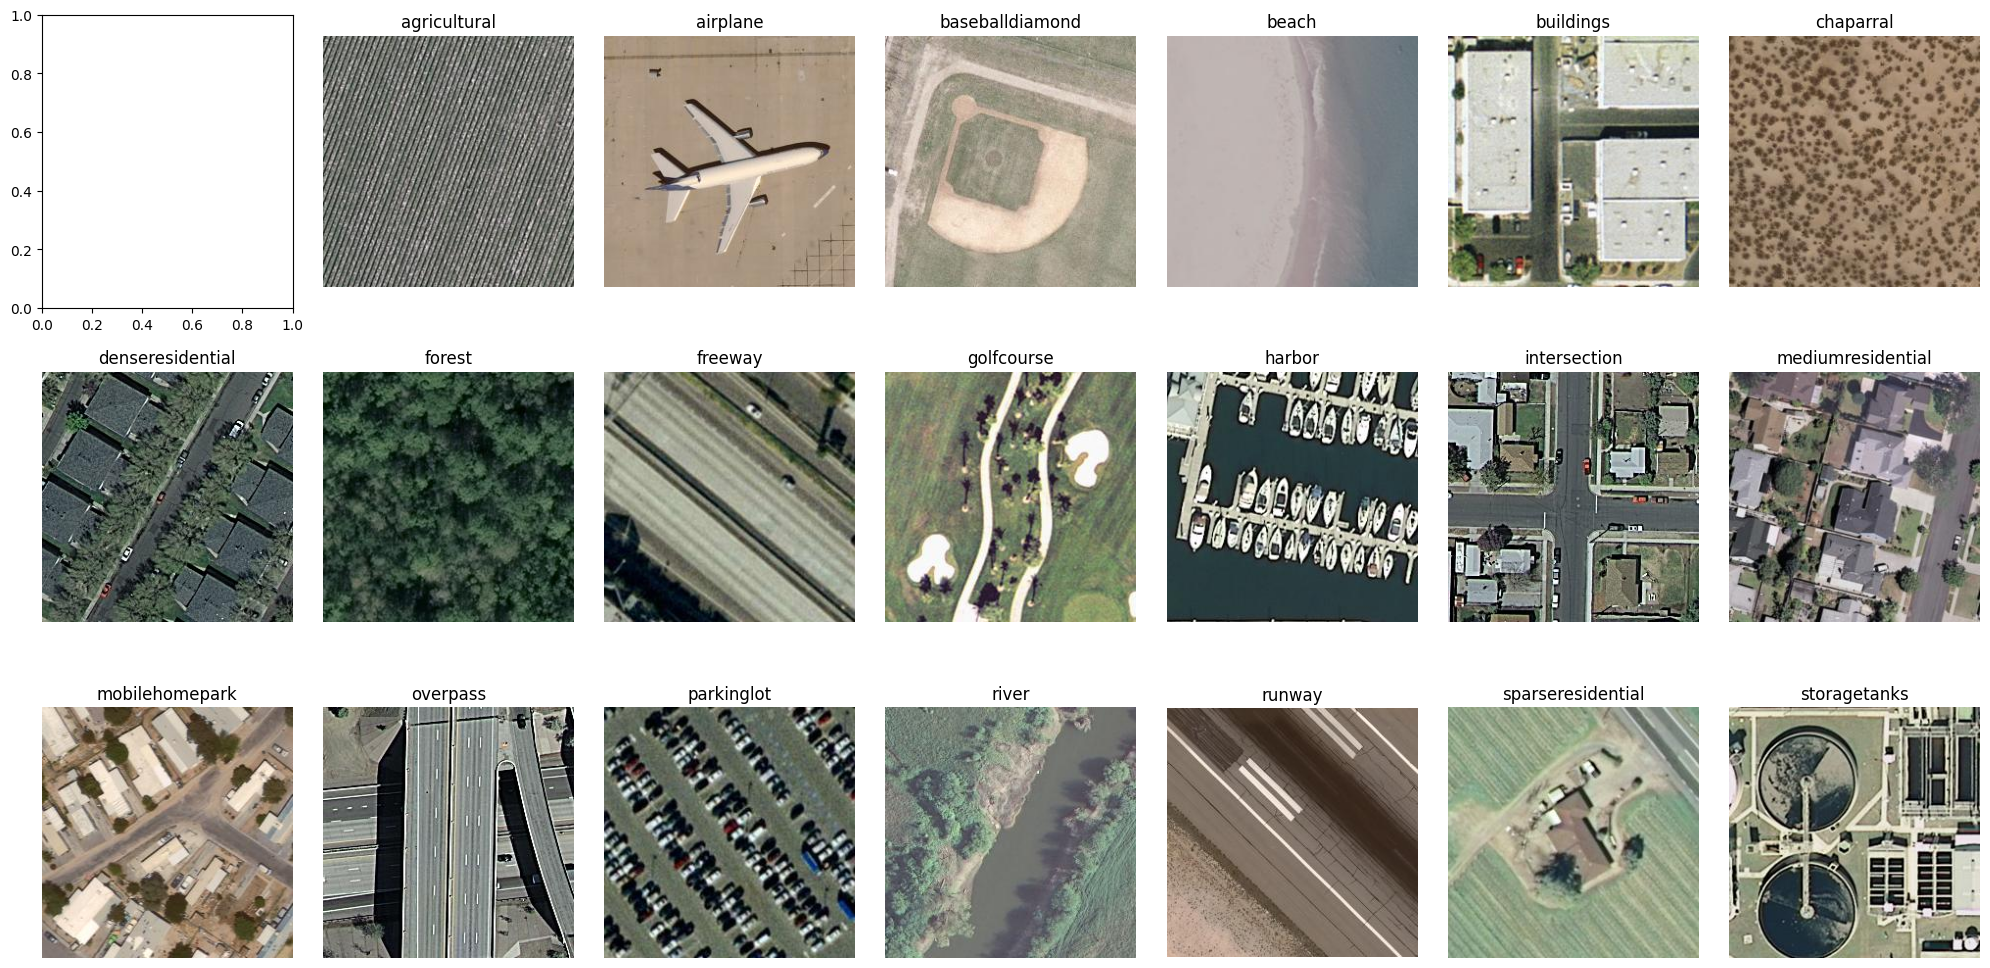

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

dataset_path = "UCMerced_LandUse/UCMerced_LandUse/Images_converted"

classes = sorted(os.listdir(dataset_path))
print(f"Found {len(classes)} classes: {classes}")

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        print(f"{class_name}: {len(images)} images")
        
fig, axes = plt.subplots(3, 7, figsize=(20, 10))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    if i >= len(axes): break
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
        img = Image.open(sample_img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')
        
plt.tight_layout()
plt.show()

In [3]:
dataset_path = "/Users/hrudaydivakaran/Desktop/Quantum_proj/UCMerced_LandUse/UCMerced_LandUse/Images_converted"

In [4]:
import os

print(os.listdir(dataset_path))

['forest', 'buildings', 'river', 'mobilehomepark', '.DS_Store', 'harbor', 'golfcourse', 'agricultural', 'runway', 'baseballdiamond', 'overpass', 'chaparral', 'tenniscourt', 'intersection', 'airplane', 'parkinglot', 'sparseresidential', 'mediumresidential', 'denseresidential', 'beach', 'freeway', 'storagetanks']


In [5]:
def preprocess_image(image_path, target_size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    flattened = img_array.flatten()
    return flattened
# Get only class folders (exclude files like .DS_Store)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
sample_class = classes[0]
sample_img_path = os.path.join(dataset_path, sample_class, os.listdir(os.path.join(dataset_path, sample_class))[0])
processed_img = preprocess_image(sample_img_path)
print(f"Processed image shape: {processed_img.shape}")
print(f"Value range: [{processed_img.min()}, {processed_img.max()}]")

Processed image shape: (1024,)
Value range: [0.03529411764705882, 0.4470588235294118]


Quantum circuit depth: 14
Number of gates: 36


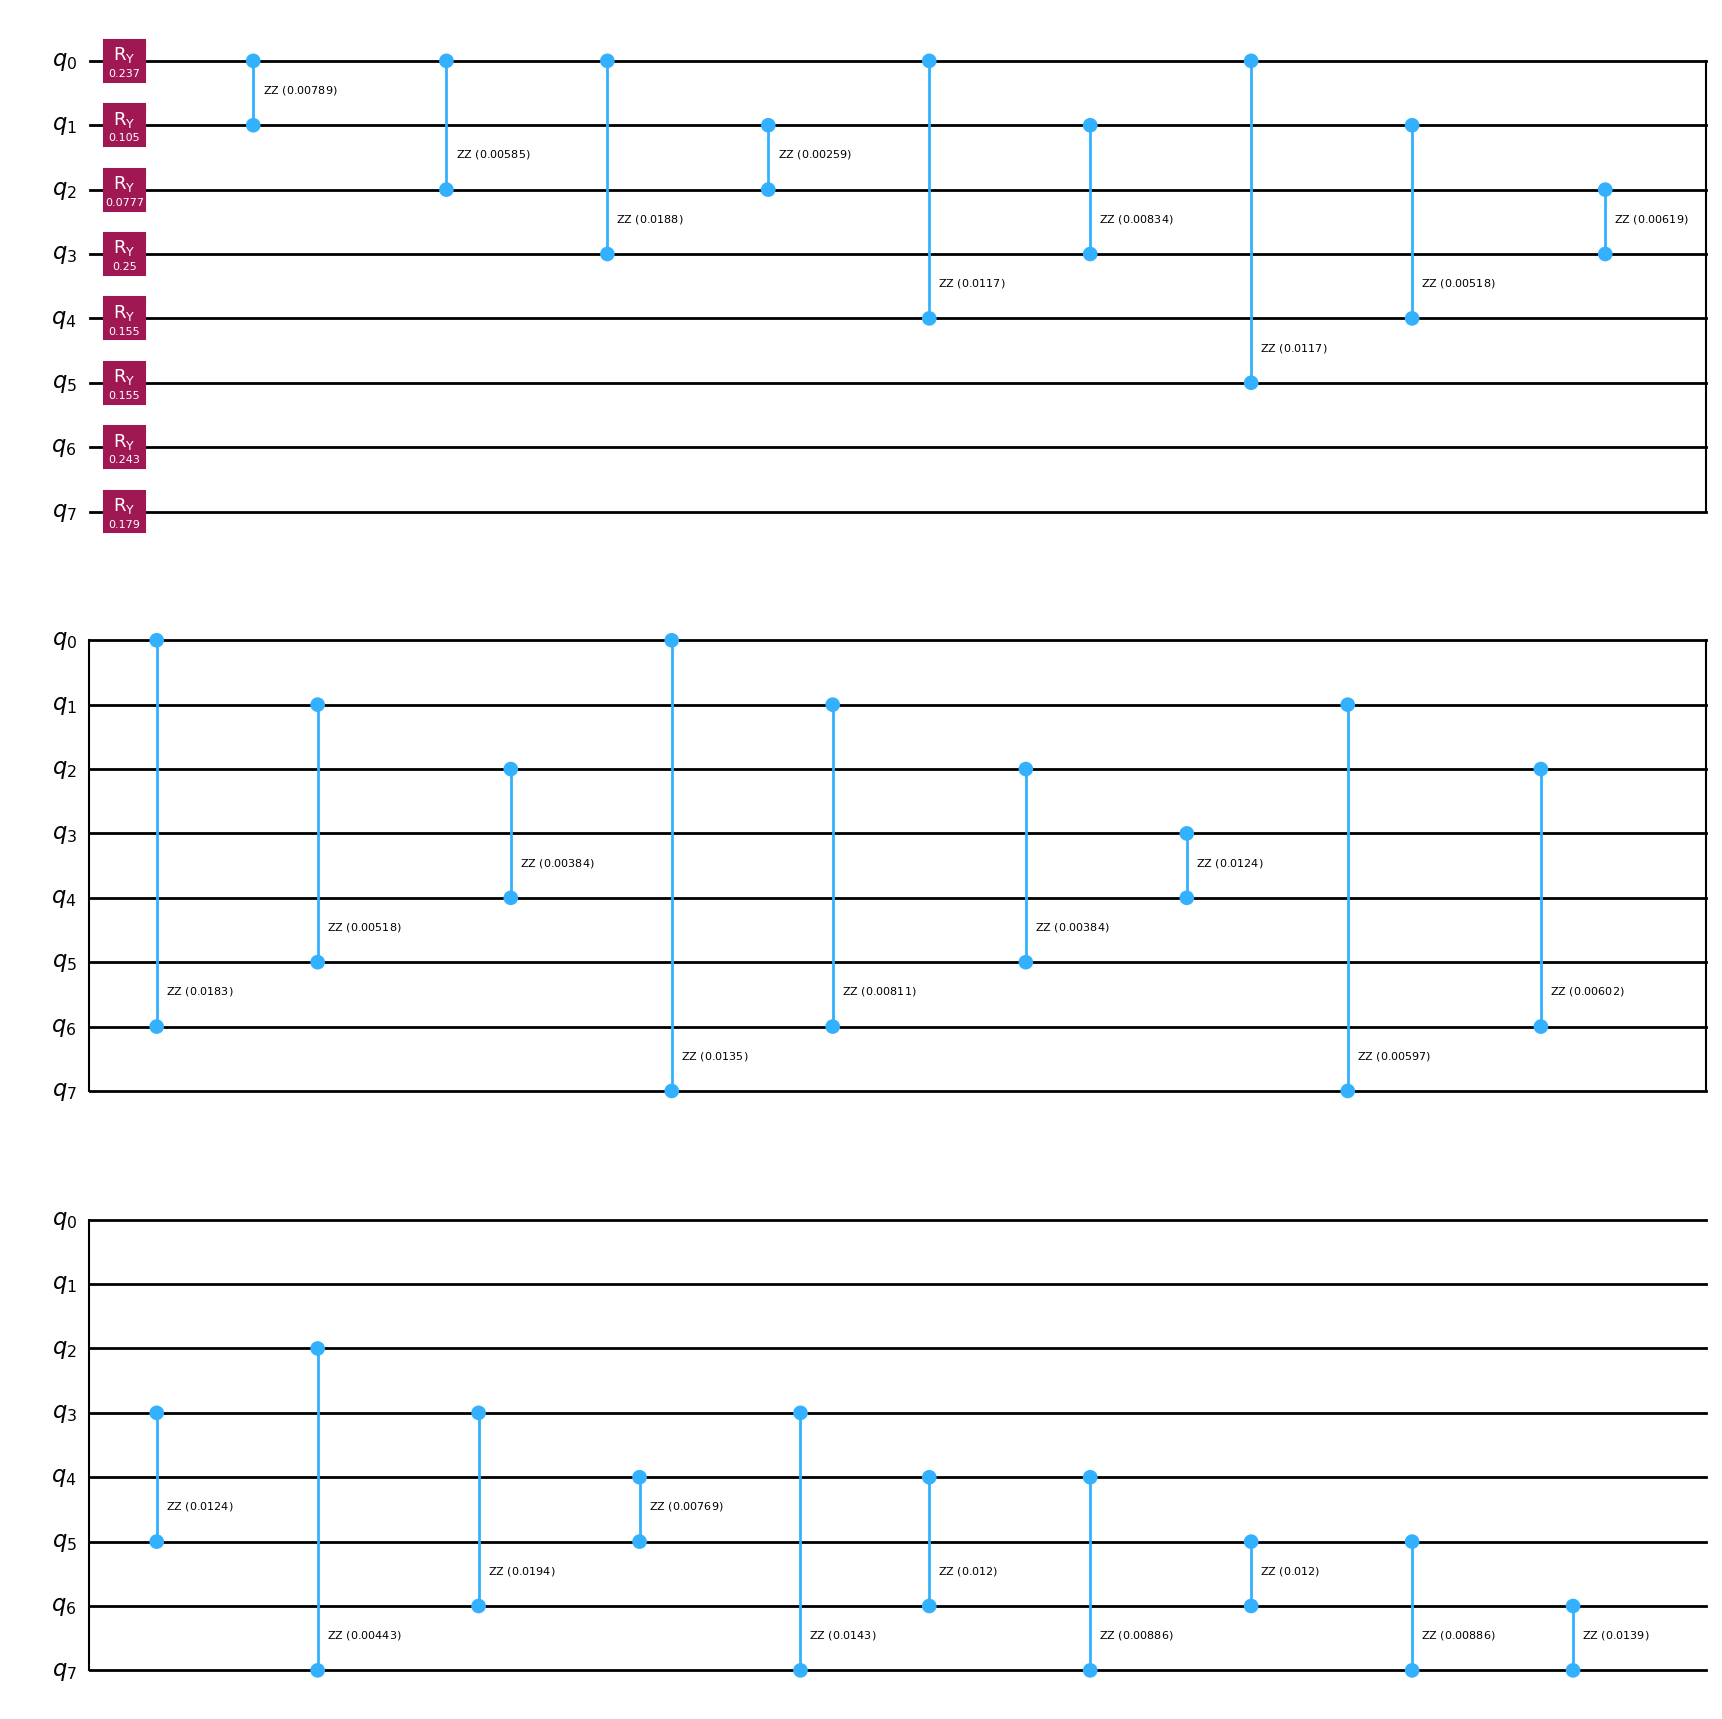

In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import qiskit.quantum_info as qi

def quantum_encode_image(image_data, num_qubits=8):
    if len(image_data) > 2**num_qubits:
        indices = np.linspace(0, len(image_data)-1, 2**num_qubits, dtype=int)
        reduced_data = image_data[indices]
    else:
        reduced_data = image_data
    
    reduced_data = reduced_data / np.linalg.norm(reduced_data)
    
    qc = QuantumCircuit(num_qubits)
    
    for i in range(num_qubits):
        if i < len(reduced_data):
            qc.ry(reduced_data[i] * np.pi, i)
    
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            if i < len(reduced_data) and j < len(reduced_data):
                qc.rzz(reduced_data[i] * reduced_data[j] * np.pi, i, j)
    
    return qc

test_qc = quantum_encode_image(processed_img)
print(f"Quantum circuit depth: {test_qc.depth()}")
print(f"Number of gates: {sum(test_qc.count_ops().values())}")
test_qc.draw(output='mpl')

In [7]:
def extract_quantum_features(quantum_circuit, shots=1024):
    qc_z = quantum_circuit.copy()
    qc_z.measure_all()
    
    qc_x = quantum_circuit.copy()
    qc_x.h(range(qc_x.num_qubits))
    qc_x.measure_all()
    
    simulator = Aer.get_backend('qasm_simulator')
    job_z = simulator.run(qc_z, shots=shots).result()
    job_x = simulator.run(qc_x, shots=shots).result()
    
    result_z = job_z.get_counts()
    result_x = job_x.get_counts()
    
    z_features = np.zeros(2**quantum_circuit.num_qubits)
    x_features = np.zeros(2**quantum_circuit.num_qubits)
    
    for state, count in result_z.items():
        idx = int(state, 2)
        z_features[idx] = count / shots
        
    for state, count in result_x.items():
        idx = int(state, 2)
        x_features[idx] = count / shots
    
    features = np.concatenate([z_features, x_features])
    
    return features

test_features = extract_quantum_features(test_qc)
print(f"Quantum feature vector shape: {test_features.shape}")

Quantum feature vector shape: (512,)


In [8]:
def shor_based_classifier(quantum_features, num_qubits=6):
    qc = QuantumCircuit(num_qubits)
    
    angles = np.arcsin(quantum_features[:num_qubits] * np.pi)
    for i, angle in enumerate(angles):
        if i < num_qubits:
            qc.ry(angle, i)
    
    # Implement custom QFT since we can't import QFT directly
    for i in range(num_qubits):
        qc.h(i)
        for j in range(i+1, num_qubits):
            qc.cp(np.pi/float(2**(j-i)), i, j)
    
    # Swap qubits
    for i in range(num_qubits//2):
        qc.swap(i, num_qubits-i-1)
    
    qc.measure_all()
    
    simulator = Aer.get_backend('qasm_simulator')
    job = simulator.run(qc, shots=1024).result()
    result = job.get_counts()
    
    shor_features = np.zeros(2**num_qubits)
    for state, count in result.items():
        idx = int(state, 2)
        shor_features[idx] = count / 1024
    
    return shor_features

shor_features = shor_based_classifier(test_features)
print(f"Shor-based features: {shor_features.shape}")

Shor-based features: (64,)


/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_5767/3128458659.py:4: RuntimeWarning: invalid value encountered in arcsin
  angles = np.arcsin(quantum_features[:num_qubits] * np.pi)


In [6]:
! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from skimage.transform import resize

def extract_quantum_features(image, target_size=(4, 4)):
    # Resize and normalize image
    gray_image = resize(image, target_size, anti_aliasing=True)
    gray_image = gray_image / np.linalg.norm(gray_image)
    
    # Flatten and normalize
    flat_data = gray_image.flatten()
    flat_data = flat_data / np.linalg.norm(flat_data)
    
    # Create a quantum circuit with log2(n) qubits
    num_qubits = int(np.log2(len(flat_data)))
    qc = QuantumCircuit(num_qubits)
    
    # Initialize state using amplitude encoding
    qc.initialize(flat_data, qc.qubits)
    
    # Simulate the circuit and return the statevector as a feature
    state = Statevector.from_instruction(qc)
    return np.real(state.data)

In [10]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

def extract_quantum_features(image, target_size=(4, 4)):
    from skimage.color import rgb2gray
    from skimage.transform import resize

    # Step 1: Preprocess image
    image = rgb2gray(image)
    image_resized = resize(image, target_size, anti_aliasing=True)
    image_flat = image_resized.flatten()
    norm_image = image_flat / np.linalg.norm(image_flat)

    num_qubits = int(np.ceil(np.log2(len(norm_image))))
    padded = np.zeros(2 ** num_qubits)
    padded[:len(norm_image)] = norm_image

    # Step 2: Encode into quantum state
    qc = QuantumCircuit(num_qubits)
    sv = Statevector(padded)
    sv = sv.evolve(qc)

    # Step 3: Use statevector as features
    features = np.real(sv.data)  # or np.concatenate([sv.data.real, sv.data.imag]) for complex part

    return features

In [11]:
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

NameError: name 'X' is not defined

In [13]:
for class_name in classes:
    for filename in os.listdir(os.path.join(dataset_path, class_name)):
        ...

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np

def prepare_dataset(dataset_path, num_samples_per_class=10):
    X = []
    y = []
    class_to_idx = {}
    
    for idx, class_name in enumerate(classes):  # Make sure 'classes' is defined somewhere
        class_to_idx[class_name] = idx
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)[:num_samples_per_class]
            
            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                try:
                    processed_img = preprocess_image(img_path)  # Assuming you have a valid preprocessing function
                    qc = quantum_encode_image(processed_img)   # Assuming quantum encoding works here
                    q_features = extract_quantum_features(qc)  # Assuming feature extraction is correct
                    shor_features = shor_based_classifier(q_features)  # This should output a valid feature vector
                    
                    # Ensure the features are flattened to a 1D array
                    shor_features = np.array(shor_features).flatten()

                    # Check if the feature shape is consistent
                    if shor_features.ndim != 1:
                        print(f"⚠️ Feature shape issue at {img_path} => shape: {shor_features.shape}")
                        continue
                    
                    X.append(shor_features)
                    y.append(idx)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return np.array(X), np.array(y), class_to_idx


# Assuming you have the `dataset_path` and `classes` defined
X, y, class_mapping = prepare_dataset(dataset_path, num_samples_per_class=3)
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy:.4f}")

# Map the labels back to class names
idx_to_class = {v: k for k, v in class_mapping.items()}
y_test_labels = [idx_to_class[i] for i in y_test]
y_pred_labels = [idx_to_class[i] for i in y_pred]

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))

Error processing /Users/hrudaydivakaran/Desktop/Quantum_proj/UCMerced_LandUse/UCMerced_LandUse/Images_converted/forest/forest49.jpg: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (36, 3) + inhomogeneous part.
Error processing /Users/hrudaydivakaran/Desktop/Quantum_proj/UCMerced_LandUse/UCMerced_LandUse/Images_converted/forest/forest75.jpg: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (36, 3) + inhomogeneous part.
Error processing /Users/hrudaydivakaran/Desktop/Quantum_proj/UCMerced_LandUse/UCMerced_LandUse/Images_converted/forest/forest61.jpg: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (36, 3) + inhomogeneous part.
Error processing /Users/hrudaydivakaran/Desktop/Quantum_proj/UCMerced_LandUse/UCMerced_LandUse/Images_converted/bui

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [15]:
def prepare_dataset(dataset_path, num_samples_per_class=10):
    X = []
    y = []
    class_to_idx = {}
    
    for idx, class_name in enumerate(classes):
        class_to_idx[class_name] = idx
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)[:num_samples_per_class]
            
            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                try:
                    processed_img = preprocess_image(img_path)
                    print(f"Processed image shape: {processed_img.shape}")
                    
                    qc = quantum_encode_image(processed_img)
                    print(f"Quantum encoded image shape: {qc.shape}")
                    
                    q_features = extract_quantum_features(qc)
                    print(f"Extracted quantum features shape: {q_features.shape}")
                    
                    shor_features = shor_based_classifier(q_features)
                    print(f"Shape of shor_features before flattening: {shor_features.shape}")
                    
                    # Flatten to 1D if needed
                    shor_features = np.array(shor_features).flatten()
                    
                    if shor_features.ndim != 1:
                        print(f"⚠️ Feature shape issue at {img_path} => shape: {shor_features.shape}")
                        continue
                    
                    X.append(shor_features)
                    y.append(idx)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return np.array(X), np.array(y), class_to_idx


In [16]:
from skimage.io import imread

img_path = 'UCMerced_LandUse/UCMerced_LandUse/Images_converted/agricultural/agricultural09.jpg'
img = imread(img_path)

features = extract_quantum_features(img)
print("Quantum features shape:", features.shape)

Quantum features shape: (16,)


In [17]:
def prepare_dataset(dataset_path, num_samples_per_class=3):
    X = []
    y = []
    class_mapping = {}
    label = 0
    
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        class_mapping[label] = class_name
        images_processed = 0
        
        for file_name in os.listdir(class_dir):
            if not file_name.endswith('.jpg'):
                continue

            file_path = os.path.join(class_dir, file_name)
            try:
                image = imread(file_path)
                features = extract_quantum_features(image)
                X.append(features)
                y.append(label)
                images_processed += 1
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
            
            if images_processed >= num_samples_per_class:
                break

        label += 1

    return np.array(X), np.array(y), class_mapping

In [18]:
X, y, class_mapping = prepare_dataset(dataset_path, num_samples_per_class=3)
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Dataset shape: (63, 16), Labels shape: (63,)


In [19]:
dataset_path = input("Enter the path to the dataset: ")

In [1]:
import os
print(os.listdir(dataset_path))

NameError: name 'dataset_path' is not defined

In [2]:
dataset_path = "UCMerced_LandUse/Images_converted"

In [20]:
import os
print(os.listdir(dataset_path))

FileNotFoundError: [Errno 2] No such file or directory: ''

In [21]:
def classify_satellite_image(image_path, model, class_mapping):
    processed_img = preprocess_image(image_path)
    qc = quantum_encode_image(processed_img)
    q_features = extract_quantum_features(qc)
    shor_features = shor_based_classifier(q_features)
    pred_idx = model.predict([shor_features])[0]
    predicted_class = class_mapping[pred_idx]
    probs = model.predict_proba([shor_features])[0]
    confidence = probs[pred_idx]
    return predicted_class, confidence

idx_to_class = {v: k for k, v in class_mapping.items()}
sample_img_path = os.path.join(dataset_path, classes[0], os.listdir(os.path.join(dataset_path, classes[0]))[0])

predicted_class, confidence = classify_satellite_image(sample_img_path, clf, idx_to_class)
print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")

img = Image.open(sample_img_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'forest'

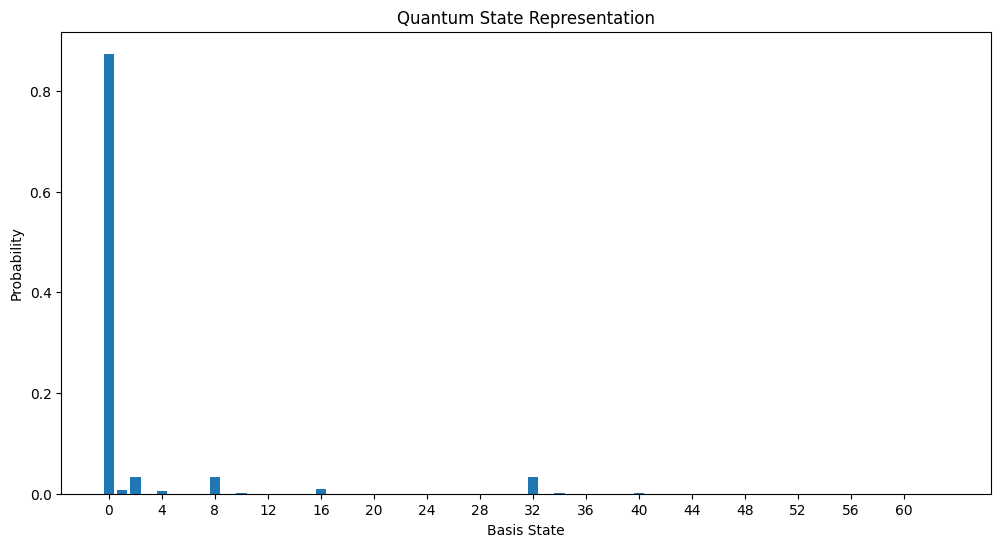

In [30]:
def visualize_quantum_state(qc, num_qubits=6):
    simulator = Aer.get_backend('statevector_simulator')
    state = qi.Statevector.from_instruction(qc)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(2**num_qubits), np.abs(state.data[:2**num_qubits])**2)
    plt.xlabel('Basis State')
    plt.ylabel('Probability')
    plt.title('Quantum State Representation')
    plt.xticks(range(0, 2**num_qubits, 2**num_qubits//16))
    plt.show()

sample_qc = quantum_encode_image(processed_img, num_qubits=6)
visualize_quantum_state(sample_qc)

In [20]:
dataset_path = "/Users/hrudaydivakaran/Desktop/Quantum_proj/UCMerced_LandUse/UCMerced_LandUse/Images_converted"

In [21]:
import os

print(os.listdir(dataset_path))

['forest', 'buildings', 'river', 'mobilehomepark', '.DS_Store', 'harbor', 'golfcourse', 'agricultural', 'runway', 'baseballdiamond', 'overpass', 'chaparral', 'tenniscourt', 'intersection', 'airplane', 'parkinglot', 'sparseresidential', 'mediumresidential', 'denseresidential', 'beach', 'freeway', 'storagetanks']
